# DRL Based Self Driving Car Control (Image)

## DQN

This notebook is DRL code for the project 'DRL based Self Driving Car Control' <br>
This version uses **Image data from camera** as input

### Import python libraries 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import random
import datetime
import os
import time

from unityagents import UnityEnvironment

%matplotlib inline

C:\Users\Q\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Set environment path

Be sure to set `env_name` to the name of the Unity environment file you want to launch.

In [2]:
env_name = "../environment/jeju_camp" # Name of the Unity environment to launch
train_mode = True # Whether to run the environment in training or inference mode

### Start the environment
`UnityEnvironment` launches and begins communication with the environment when instantiated.

Environments contain _brains_ which are responsible for deciding the actions of their associated _agents_. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
env = UnityEnvironment(file_name=env_name)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]
brain = env.brains[default_brain]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: Brain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 373
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 5
        Vector Action descriptions: , , , , 


Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: Brain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 373
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 5
        Vector Action descriptions: , , , , 


### Examine the observation and state spaces
We can reset the environment to be provided with an initial set of observations and states for all the agents within the environment. In ML-Agents, _states_ refer to a vector of variables corresponding to relevant aspects of the environment for an agent. Likewise, _observations_ refer to a set of relevant pixel-wise visuals for an agent.

Sensor data (LIDAR): 
[  1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.
   0.9755246    0.91600198   0.86357307   0.81705666   0.77551937
   0.73821479   0.70453942   0.67399871   0.64618438   0.62075633
   0.59742886   0.57596022   0.5561446    0.53780544   0.52079082
   0.50496876   0.49022466   0.47645816   0.46358114   0.45151567
   0.44019303   0.42955208   0.41953811   0.41010255   0.40120158
   0.39279586   0.38485005   0.37733197   0.37021253   0.36346549
   0.35706681   0.35099453   0.34522879   0.33975118   0.33454502
   0.32959491   0.32488668   0.32040724   0.31614468   0.31208783
   0.30822647   0.30455115   0.30105308   0.29772413   0.29455668
   0.29154381   0.288679     0.28595623   0.28336981   0.2809146
   0.27858567   0.27637851   0.27428898   0.27231315   0.27044734
   0.26868826   0.26703268   0.26547778   0.26402083   0.26265934
   0.26139107

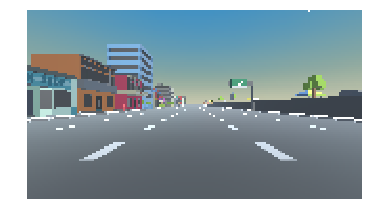

In [4]:
# Reset the environment
env_info = env.reset(train_mode=train_mode)[default_brain]

# Examine the state space for the default brain
print("Sensor data (LIDAR): \n{}".format(env_info.vector_observations[0]))

# Examine the observation space for the default brain
Num_obs = len(env_info.visual_observations)

print("Image data (Front Camera): \n{}")
if Num_obs > 1:
    f, axarr = plt.subplots(1, Num_obs, figsize=(20,10))
    for i, observation in enumerate(env_info.visual_observations):
        if observation.shape[3] == 3:
            axarr[i].imshow(observation[0,:,:,:])
            axarr[i].axis('off')
        else:
            axarr[i].imshow(observation[0,:,:,0])
            axarr[i].axis('off')
else:
    f, axarr = plt.subplots(1, Num_obs)
    for i, observation in enumerate(env_info.visual_observations):
        if observation.shape[3] == 3:
            axarr.imshow(observation[0,:,:,:])
            axarr.axis('off')
        else:
            axarr.imshow(observation[0,:,:,0])
            axarr.axis('off')

### Set Parameters

In [5]:
algorithm = 'DQN'
Num_action = brain.vector_action_space_size

# parameter for DQN
Num_replay_memory = 100000
Num_start_training = 50000
Num_training = 1000000
Num_update = 10000
Num_batch = 32
Num_test = 100000
Num_skipFrame = 4
Num_stackFrame = 4
Num_colorChannel = 1

Epsilon = 1.0
Final_epsilon = 0.1
Gamma = 0.99
Learning_rate = 0.00025

# Parameters for network
img_size = 80
sensor_size = 360

first_conv   = [8,8,Num_colorChannel * Num_stackFrame * Num_obs,32]
second_conv  = [4,4,32,64]
third_conv   = [3,3,64,64]
first_dense  = [10*10*64, 512]
second_dense = [first_dense[1], Num_action]

# Path of the network model
load_path = ''

# Parameters for session
Num_plot_episode = 5
Num_step_save = 50000

GPU_fraction = 0.4

### Functions for Networks

In [6]:
# Initialize weights and bias
def weight_variable(shape):
    return tf.Variable(xavier_initializer(shape))

def bias_variable(shape):
	return tf.Variable(xavier_initializer(shape))

# Xavier Weights initializer
def xavier_initializer(shape):
	dim_sum = np.sum(shape)
	if len(shape) == 1:
		dim_sum += 1
	bound = np.sqrt(2.0 / dim_sum)
	return tf.random_uniform(shape, minval=-bound, maxval=bound)

# Convolution function
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

# Assign network variables to target network
def assign_network_to_target():
	# Get trainable variables
	trainable_variables = tf.trainable_variables()
	# network lstm variables
	trainable_variables_network = [var for var in trainable_variables if var.name.startswith('network')]

	# target lstm variables
	trainable_variables_target = [var for var in trainable_variables if var.name.startswith('target')]

    # assign network variables to target network
	for i in range(len(trainable_variables_network)):
		sess.run(tf.assign(trainable_variables_target[i], trainable_variables_network[i]))

# Code for tensorboard
def setup_summary():
    episode_speed      = tf.Variable(0.)
    episode_overtake   = tf.Variable(0.)
    episode_lanechange = tf.Variable(0.)

    tf.summary.scalar('Average_Speed/' + str(Num_plot_episode) + 'episodes', episode_speed)
    tf.summary.scalar('Average_overtake/' + str(Num_plot_episode) + 'episodes', episode_overtake)
    tf.summary.scalar('Average_lanechange/' + str(Num_plot_episode) + 'episodes', episode_lanechange)

    summary_vars = [episode_speed, episode_overtake, episode_lanechange]
    summary_placeholders = [tf.placeholder(tf.float32) for _ in range(len(summary_vars))]
    update_ops = [summary_vars[i].assign(summary_placeholders[i]) for i in range(len(summary_vars))]
    summary_op = tf.summary.merge_all()
    return summary_placeholders, update_ops, summary_op

### Network

In [7]:
tf.reset_default_graph()

# Input
x_image = tf.placeholder(tf.float32, shape = [None, img_size, img_size, Num_colorChannel * Num_stackFrame * Num_obs])
x_normalize = (x_image - (255.0/2)) / (255.0/2)

with tf.variable_scope('network'):
    # Convolution variables
    w_conv1 = weight_variable(first_conv)
    b_conv1 = bias_variable([first_conv[3]])

    w_conv2 = weight_variable(second_conv)
    b_conv2 = bias_variable([second_conv[3]])

    w_conv3 = weight_variable(third_conv)
    b_conv3 = bias_variable([third_conv[3]])

    # Densely connect layer variables
    w_fc1 = weight_variable(first_dense)
    b_fc1 = bias_variable([first_dense[1]])

    w_fc2 = weight_variable(second_dense)
    b_fc2 = bias_variable([second_dense[1]])
    
# Network
h_conv1 = tf.nn.relu(conv2d(x_normalize, w_conv1, 4) + b_conv1)
h_conv2 = tf.nn.relu(conv2d(h_conv1, w_conv2, 2) + b_conv2)
h_conv3 = tf.nn.relu(conv2d(h_conv2, w_conv3, 1) + b_conv3)

h_conv3_flat = tf.reshape(h_conv3, [-1, 10 * 10 * 64])

h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, w_fc1)+b_fc1)
output = tf.matmul(h_fc1,  w_fc2)+b_fc2

with tf.variable_scope('target'):
    # Convolution variables target
    w_conv1_target = weight_variable(first_conv)
    b_conv1_target = bias_variable([first_conv[3]])

    w_conv2_target = weight_variable(second_conv)
    b_conv2_target = bias_variable([second_conv[3]])

    w_conv3_target = weight_variable(third_conv)
    b_conv3_target = bias_variable([third_conv[3]])

    # Densely connect layer variables target
    w_fc1_target = weight_variable(first_dense)
    b_fc1_target = bias_variable([first_dense[1]])

    w_fc2_target = weight_variable(second_dense)
    b_fc2_target = bias_variable([second_dense[1]])

    
# Target Network
h_conv1_target = tf.nn.relu(conv2d(x_normalize, w_conv1_target, 4) + b_conv1_target)
h_conv2_target = tf.nn.relu(conv2d(h_conv1_target, w_conv2_target, 2) + b_conv2_target)
h_conv3_target = tf.nn.relu(conv2d(h_conv2_target, w_conv3_target, 1) + b_conv3_target)

h_conv3_flat_target = tf.reshape(h_conv3_target, [-1, 10 * 10 * 64])

h_fc1_target  = tf.nn.relu(tf.matmul(h_conv3_flat_target, w_fc1_target)+b_fc1_target)
output_target = tf.matmul(h_fc1_target,  w_fc2_target)+b_fc2_target

### Loss and Train

In [8]:
# Loss function and Train
action_target = tf.placeholder(tf.float32, shape = [None, Num_action])
y_target = tf.placeholder(tf.float32, shape = [None])

y_prediction = tf.reduce_sum(tf.multiply(output, action_target), reduction_indices = 1)
Loss = tf.reduce_mean(tf.square(y_prediction - y_target))
train_step = tf.train.AdamOptimizer(learning_rate = Learning_rate, epsilon = 1e-02).minimize(Loss)

### Config

In [9]:
## Initialize variables
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = GPU_fraction

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

### Training or Inference

In [10]:
# Load the file if the saved file exists
saver = tf.train.Saver()

# check_save = 1
check_save = input('Inference? / Training?(1=Inference/2=Training): ')

if check_save == '1':
    # Directly start inference
    Num_start_training = 0
    Num_training = 0
    
    # Restore variables from disk.
    saver.restore(sess, load_path)
    print("Model restored.")

# date - hour - minute of training time
date_time = str(datetime.date.today()) + '_' + str(datetime.datetime.now().hour) + '_' + str(datetime.datetime.now().minute)

# Make folder for save data
os.makedirs('../saved_networks/' + date_time + '_' + algorithm + '_image')

# Summary for tensorboard
summary_placeholders, update_ops, summary_op = setup_summary()
summary_writer = tf.summary.FileWriter('../saved_networks/' + date_time + '_' + algorithm + '_image', sess.graph)

Inference? / Training?(1=Inference/2=Training): 2


### Functions for Training

In [11]:
# Initialize input 
def input_initialization(env_info):
    # Observation
    observation_stack_obs = np.zeros([img_size, img_size, Num_colorChannel * Num_obs])
    
    for i in range(Num_obs):
        observation = 255 * env_info.visual_observations[i]
        observation = np.uint8(observation)
        observation = np.reshape(observation, (observation.shape[1], observation.shape[2], 3))
        observation = cv2.resize(observation, (img_size, img_size))

        if Num_colorChannel == 1:
            observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
            observation = np.reshape(observation, (img_size, img_size))

        if Num_colorChannel == 3:
            observation_stack_obs[:,:, Num_colorChannel * i: Num_colorChannel * (i+1)] = observation
        else:
            observation_stack_obs[:,:, i] = observation

    observation_set = []
      
    for i in range(Num_skipFrame * Num_stackFrame):
        observation_set.append(observation_stack_obs)
        
    # Stack the frame according to the number of skipping and stacking frames using observation set
    observation_stack = np.zeros((img_size, img_size, Num_colorChannel * Num_stackFrame * Num_obs))
    
    for stack_frame in range(Num_stackFrame):
        observation_stack[:,:,Num_obs * stack_frame: Num_obs * (stack_frame+1)] = observation_set[-1 - (Num_skipFrame * stack_frame)]
    
    observation_stack = np.uint8(observation_stack)
    
    return observation_stack, observation_set

# Resize input information 
def resize_input(env_info, observation_set):
    # Stack observation according to the number of observations
    observation_stack_obs = np.zeros([img_size, img_size, Num_colorChannel * Num_obs])

    for i in range(Num_obs):
        observation = 255 * env_info.visual_observations[i]
        observation = np.uint8(observation)
        observation = np.reshape(observation, (observation.shape[1], observation.shape[2], 3))
        observation = cv2.resize(observation, (img_size, img_size))
        
        if Num_colorChannel == 1:
            observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
            observation = np.reshape(observation, (img_size, img_size))

        if Num_colorChannel == 3:
            observation_stack_obs[:,:, Num_colorChannel * i: Num_colorChannel * (i+1)] = observation
        else:
            observation_stack_obs[:,:,i] = observation
    
    # Add observations to the observation_set
    observation_set.append(observation_stack_obs)
    
    # Stack the frame according to the number of skipping and stacking frames using observation set
    observation_stack = np.zeros((img_size, img_size, Num_colorChannel * Num_stackFrame * Num_obs))

    for stack_frame in range(Num_stackFrame):
        observation_stack[:,:,Num_obs * stack_frame: Num_obs * (stack_frame+1)] = observation_set[-1 - (Num_skipFrame * stack_frame)]

    del observation_set[0]
    
    observation_stack = np.uint8(observation_stack)
        
    return observation_stack, observation_set

# Get progress according to the number of steps
def get_progress(step, Epsilon):
    if step <= Num_start_training:
        # Observation
        progress = 'Observing'
        train_mode = True
        Epsilon = 1
    elif step <= Num_start_training + Num_training:
        # Training
        progress = 'Training'
        train_mode = True
        
        # Decrease the epsilon value
        if Epsilon > Final_epsilon:
            Epsilon -= 1.0/Num_training
    elif step < Num_start_training + Num_training + Num_test:
        # Testing
        progress = 'Testing'
        train_mode = False
        Epsilon = 0
    else:
        # Finished
        progress = 'Finished'
        train_mode = False
        Epsilon = 0
        
    return progress, train_mode, Epsilon 

# Select action according to the progress of training
def select_action(progress, sess, observation_stack, Epsilon):
    if progress == "Observing":
        # Random action 
        Q_value = 0
        action = np.zeros([Num_action])
        action[random.randint(0, Num_action - 1)] = 1.0
    elif progress == "Training":
        # if random value(0-1) is smaller than Epsilon, action is random. 
        # Otherwise, action is the one which has the max Q value
        if random.random() < Epsilon:
            Q_value = 0
            action = np.zeros([Num_action])
            action[random.randint(0, Num_action - 1)] = 1
        else:
            Q_value = output.eval(feed_dict={x_image: [observation_stack]})
            action = np.zeros([Num_action])
            action[np.argmax(Q_value)] = 1
    else:
        # Max Q action 
        Q_value = output.eval(feed_dict={x_image: [observation_stack]})
        action = np.zeros([Num_action])
        action[np.argmax(Q_value)] = 1
        
    return action, Q_value

def train(Replay_memory, sess, step):
    # Select minibatch
    minibatch =  random.sample(Replay_memory, Num_batch)

    # Save the each batch data
    observation_batch      = [batch[0] for batch in minibatch]
    action_batch           = [batch[1] for batch in minibatch]
    reward_batch           = [batch[2] for batch in minibatch]
    observation_next_batch = [batch[3] for batch in minibatch]
    terminal_batch 	       = [batch[4] for batch in minibatch]

    # Update target network according to the Num_update value
    if step % Num_update == 0:
        assign_network_to_target()
    
    # Get y_target
    y_batch = []
    Q_target = output_target.eval(feed_dict = {x_image: observation_next_batch})

    # Get target values
    for i in range(len(minibatch)):
        if terminal_batch[i] == True:
            y_batch.append(reward_batch[i])
        else:
            y_batch.append(reward_batch[i] + Gamma * np.max(Q_target[i]))

    _, loss = sess.run([train_step, Loss], feed_dict = {action_target: action_batch, 
                                                        y_target: y_batch, 
                                                        x_image: observation_batch})

# Experience Replay 
def Experience_Replay(progress, Replay_memory, obs_stack, action, reward, next_obs_stack, terminal):
    if progress != 'Testing':
        # If length of replay memeory is more than the setting value then remove the first one
        if len(Replay_memory) > Num_replay_memory:
            del Replay_memory[0]

        # Save experience to the Replay memory
        Replay_memory.append([obs_stack, action, reward, next_obs_stack, terminal])
    else:
        # Empty the replay memory if testing
        Replay_memory = []
    
    return Replay_memory

### Initialize Variables

In [12]:
# Initial parameters
Replay_memory = []

step = 1
score = 0
score_board = 0

episode = 0
step_per_episode = 0

speed_list = []
overtake_list = []
lanechange_list = []

train_mode = True
env_info = env.reset(train_mode=train_mode)[default_brain]

observation_stack, observation_set = input_initialization(env_info)

### Training

In [ ]:
check_plot = 0

# Training & Testing
while True:
   
    # Get Progress, train mode
    progress, train_mode, Epsilon  = get_progress(step, Epsilon)
    
    # Select Actions 
    action, Q_value = select_action(progress, sess, observation_stack, Epsilon)
    action_in = [np.argmax(action)]
    
    # Get information for plotting
    vehicle_speed  = 100 * env_info.vector_observations[0][-8]
    num_overtake   = env_info.vector_observations[0][-7]
    num_lanechange = env_info.vector_observations[0][-6]
    
    # Get information for update
    env_info = env.step(action_in)[default_brain]

    next_observation_stack, observation_set = resize_input(env_info, observation_set) 
    reward = env_info.rewards[0]
    terminal = env_info.local_done[0]
    
    if progress == 'Training':
        # Train!! 
        train(Replay_memory, sess, step)

        # Save the variables to disk.
        if step == Num_start_training + Num_training:
            save_path = saver.save(sess, '../saved_networks/' + date_time + '_' + algorithm + '_image' + "/model.ckpt")
            print("Model saved in file: %s" % save_path)
    
    # If progress is finished -> close! 
    if progress == 'Finished':
        print('Finished!!')
        env.close()
        break
        
    Replay_memory = Experience_Replay(progress, 
                                      Replay_memory, 
                                      observation_stack,
                                      action, 
                                      reward, 
                                      next_observation_stack,
                                      terminal)
    
    # Update information
    step += 1
    score += reward
    step_per_episode += 1
    
    observation_stack = next_observation_stack
    
    # Update tensorboard
    if progress != 'Observing':
        speed_list.append(vehicle_speed)
        
        if episode % Num_plot_episode == 0 and check_plot == 1 and episode != 0:
            avg_speed      = sum(speed_list) / len(speed_list)
            avg_overtake   = sum(overtake_list) / len(overtake_list)
            avg_lanechange = sum(lanechange_list) / len(lanechange_list)
            
            tensorboard_info = [avg_speed, avg_overtake, avg_lanechange]
            for i in range(len(tensorboard_info)):
                sess.run(update_ops[i], feed_dict = {summary_placeholders[i]: float(tensorboard_info[i])})
            summary_str = sess.run(summary_op)
            summary_writer.add_summary(summary_str, step)
            score_board = 0
            
            speed_list = []
            overtake_list = []
            lanechange_list = []

            check_plot = 0
            
    # If terminal is True
    if terminal == True:
        # Print informations
        print('step: ' + str(step) + ' / '  + 'episode: ' + str(episode) + ' / ' + 'progress: ' + progress  + ' / ' + 'epsilon: ' + str(Epsilon)  +' / ' + 'score: ' + str(score))

        check_plot = 1

        if progress != 'Observing':
            episode += 1
            
            score_board += score
            overtake_list.append(num_overtake)
            lanechange_list.append(num_lanechange)
        
            
        score = 0
        step_per_episode = 0

        # Initialize game state
        env_info = env.reset(train_mode=train_mode)[default_brain]
        observation_stack, observation_set = input_initialization(env_info)

        



step: 4907 / episode: 0 / progress: Observing / epsilon: 1 / score: 990.0109669491649
step: 9608 / episode: 0 / progress: Observing / epsilon: 1 / score: 1145.9446742013097
step: 14289 / episode: 0 / progress: Observing / epsilon: 1 / score: 1098.9082214608788
step: 18879 / episode: 0 / progress: Observing / epsilon: 1 / score: 1289.8384655714035
step: 23504 / episode: 0 / progress: Observing / epsilon: 1 / score: 1173.5075749009848
step: 27162 / episode: 0 / progress: Observing / epsilon: 1 / score: 830.3676781132817
step: 31849 / episode: 0 / progress: Observing / epsilon: 1 / score: 1138.4457378536463
step: 36666 / episode: 0 / progress: Observing / epsilon: 1 / score: 1078.5131687819958
step: 41264 / episode: 0 / progress: Observing / epsilon: 1 / score: 1298.6421379745007
step: 46016 / episode: 0 / progress: Observing / epsilon: 1 / score: 1302.6423847004771
step: 50494 / episode: 0 / progress: Training / epsilon: 0.9995069999999858 / score: 1412.0681159570813
step: 54793 / episod

step: 285886 / episode: 70 / progress: Training / epsilon: 0.764114999993217 / score: 2045.6945526376367
step: 288208 / episode: 71 / progress: Training / epsilon: 0.7617929999931502 / score: 1581.7964196652174
step: 288720 / episode: 72 / progress: Training / epsilon: 0.7612809999931355 / score: 295.07415606081486
step: 289973 / episode: 73 / progress: Training / epsilon: 0.7600279999930994 / score: 701.5243927389383
step: 293689 / episode: 74 / progress: Training / epsilon: 0.7563119999929926 / score: 2061.787966236472
step: 295238 / episode: 75 / progress: Training / epsilon: 0.754762999992948 / score: 1078.467016518116
step: 298620 / episode: 76 / progress: Training / epsilon: 0.7513809999928508 / score: 1486.1338623389602
step: 298767 / episode: 77 / progress: Training / epsilon: 0.7512339999928466 / score: 93.39466515183449
step: 302493 / episode: 78 / progress: Training / epsilon: 0.7475079999927394 / score: 2421.6355665028095
step: 306961 / episode: 79 / progress: Training / ep

step: 520856 / episode: 148 / progress: Training / epsilon: 0.5291449999864603 / score: 381.46809646487236
step: 524870 / episode: 149 / progress: Training / epsilon: 0.5251309999863448 / score: 2226.180378526449
step: 528760 / episode: 150 / progress: Training / epsilon: 0.521240999986233 / score: 2351.795525588095
step: 532611 / episode: 151 / progress: Training / epsilon: 0.5173899999861222 / score: 2394.949269115925
step: 533937 / episode: 152 / progress: Training / epsilon: 0.5160639999860841 / score: 978.9600025713444
step: 537680 / episode: 153 / progress: Training / epsilon: 0.5123209999859765 / score: 2503.7959981635213
step: 541315 / episode: 154 / progress: Training / epsilon: 0.5086859999858719 / score: 2553.1942759007215
step: 541669 / episode: 155 / progress: Training / epsilon: 0.5083319999858618 / score: 294.12499636411667
step: 545475 / episode: 156 / progress: Training / epsilon: 0.5045259999857523 / score: 2422.5647248849273
step: 545834 / episode: 157 / progress: Tr

step: 751143 / episode: 225 / progress: Training / epsilon: 0.2988579999910039 / score: 2037.313054524362
step: 754682 / episode: 226 / progress: Training / epsilon: 0.29531899999109856 / score: 2765.2912191674113
step: 758570 / episode: 227 / progress: Training / epsilon: 0.2914309999912026 / score: 2406.816291898489
step: 762435 / episode: 228 / progress: Training / epsilon: 0.287565999991306 / score: 2407.9417783766985
step: 765398 / episode: 229 / progress: Training / epsilon: 0.2846029999913853 / score: 2165.5944825708866
step: 769307 / episode: 230 / progress: Training / epsilon: 0.28069399999148986 / score: 2371.9341083541512
step: 773221 / episode: 231 / progress: Training / epsilon: 0.2767799999915946 / score: 2365.342923782766
step: 775186 / episode: 232 / progress: Training / epsilon: 0.27481499999164716 / score: 1560.3569694906473
step: 779048 / episode: 233 / progress: Training / epsilon: 0.2709529999917505 / score: 2399.4600171893835
step: 779529 / episode: 234 / progress

In [ ]:
env.close()